# Bag of word model

Pros:
- Simple Model

Cons:
- vocab
- sparsity
  - not respect to word order
  - not respect to word similarity

## Training

In [1]:
import pandas as pd
import numpy as np

### Load Data

using `FakeNewsNet` dataset

In [2]:
data_df = pd.read_pickle('../../../dataset/FakeNewsNet/data/FakeNewsNet.pkl')

data_df['label_value'] = data_df['label'].map({'true': 1, 'false': 0})
data_df.head()

,text,processed_text,label,label_value
0,On Air with Ryan Seacrest is offering you a ch...,"[air, ryan, seacrest, offer, chance, win, nigh...",false,0
1,‘American Idol’ final: How to vote for the sea...,"[american, idol, final, vote, season, winner, ...",false,0
2,@ScottDisick @KrisJenner @khloekardashian — LA...,"[latest, art, shame, revenge, prank, banksy, s...",false,0
3,@foquinha Youngblood - 5 Seconds of Summer \nO...,"[youngblood, seconds, summer, little, mix, del...",false,0
4,Kylie Jenner ‘Open’ To Reconciliation With Tyg...,"[kylie, jenner, open, reconciliation, tyga, pr...",false,0


In [3]:
from sklearn.model_selection import train_test_split


def get_shape(X, y):
    return {
        "shape": X.shape,
        "true": np.count_nonzero(y),
        "false": len(y) - np.count_nonzero(y),
    }


X_train, X_test, y_train, y_test = train_test_split(
    data_df["text"], data_df["label_value"], test_size=0.2, random_state=2023
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=2023
)

print("train", get_shape(X_train, y_train))
print("val", get_shape(X_val, y_val))
print("test", get_shape(X_test, y_test))


train {'shape': (875639,), 'true': 596727, 'false': 278912}
val {'shape': (218910,), 'true': 149047, 'false': 69863}
test {'shape': (273638,), 'true': 186595, 'false': 87043}


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import spacy
from tqdm import tqdm
import re

nlp = spacy.load("en_core_web_sm")


def transform(X, vectorizer: "TfidfVectorizer | CountVectorizer"):
    # transform and clean data
    # https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+",
        flags=re.UNICODE,
    )
    X = [emoji_pattern.sub(r"", text) for text in X]

    url_pattern = re.compile(r"(https|http)?://\S+|www\.\S+")
    X = [url_pattern.sub(r"", text) for text in X]

    # tokenization
    docs = nlp.pipe(X, disable=["parser", "ner"], n_process=-1)

    transform_X = []
    for doc in tqdm(docs, total=len(X)):
        tokens = []
        for token in doc:
            if not token.is_stop and token.is_alpha:
                tokens.append(token.lemma_)
        transform_X.append(' '.join(tokens))
    filter(lambda x: len(x) > 0, transform_X)

    transform_X = vectorizer.transform(transform_X)
    return transform_X


2023-02-01 10:09:55.572959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 10:09:56.608524: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-02-01 10:09:56.608600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2023-02-01 10:09:56.608606: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [5]:
vectorizer = TfidfVectorizer(use_idf=True)
vectorizer = vectorizer.fit(X_train)

count_vectorizer = CountVectorizer()
count_vectorizer = count_vectorizer.fit(X_train)


In [6]:
import joblib as jb
jb.dump(vectorizer, './TfidfVectorizer.joblib')
jb.dump(count_vectorizer, './CountVectorizer.joblib')


['./CountVectorizer.joblib']

In [7]:
import joblib as jb
vectorizer = jb.load('./TfidfVectorizer.joblib')
count_vectorizer = jb.load('./CountVectorizer.joblib')

In [8]:
X_vector_train = transform(X_train, vectorizer)
X_cvector_train = transform(X_train, count_vectorizer)

100%|██████████| 875639/875639 [03:27<00:00, 4216.99it/s]


#### idf data

In [9]:
df_idf = pd.DataFrame(
    vectorizer.idf_, index=vectorizer.get_feature_names_out(), columns=["idf_weights"]
)
df_idf.sort_values(by=["idf_weights"]).head(10)


,idf_weights
the,1.824513
to,2.176555
and,2.187351
of,2.311556
in,2.455126
is,2.627362
on,2.701808
for,2.787725
with,2.870644
at,3.305891


### Model Training

In [10]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import LearningCurveDisplay

In [11]:
# transform val data
X_vector_val = transform(X_val, vectorizer)
X_cvector_val = transform(X_val, count_vectorizer)

100%|██████████| 218910/218910 [00:53<00:00, 4062.41it/s]


In [12]:
X_vector_train.shape

(875639, 247558)

In [13]:
# SVC Model
from sklearn.svm import SVC

clf_svc = SVC(kernel="rbf", C=1.0, random_state=2023)
clfc_svc = SVC(kernel="rbf", C=1.0, random_state=2023)
# clf_svc.fit(X_vector_train, y_train)

In [14]:
from sklearn.naive_bayes import BernoulliNB

clf_nb = BernoulliNB()
clfc_nb = BernoulliNB()
# clf_nb.fit(X_vector_train, y_train)

/home/kooler/dev/sw/sns-fake-content/model/env_model/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

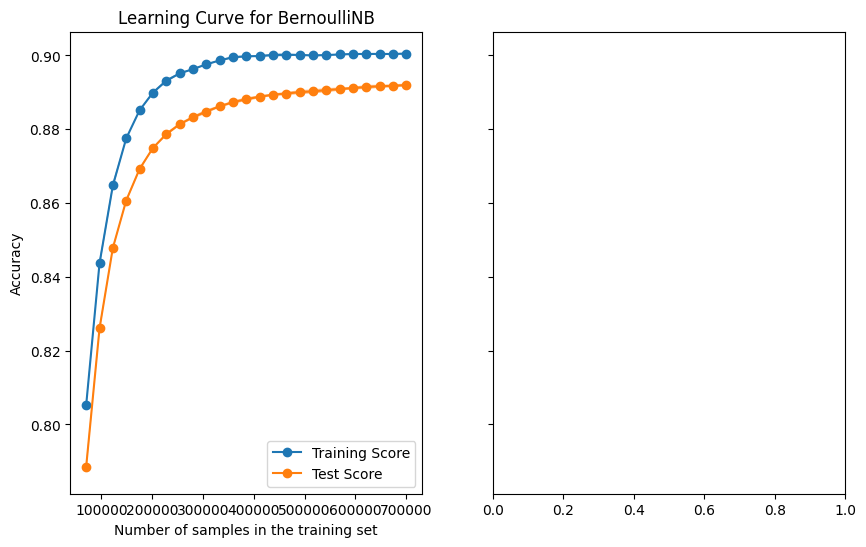

In [15]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_cvector_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 25),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clf_nb, clf_svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_vector_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 25),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clfc_nb, clfc_svc]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
print("classification_report SVC")
print(classification_report(y_val, clf_svc.predict(X_vector_val)))
print("classification_report NB")
print(classification_report(y_val, clf_nb.predict(X_vector_val)))

jb.dump(clf_nb, './model/NB.joblib')
jb.dump(clf_svc, './model/SVC.joblib')

In [ ]:
print("classification_report SVC (Count)")
print(classification_report(y_val, clfc_svc.predict(X_cvector_val)))
print("classification_report NB (Count)")
print(classification_report(y_val, clfc_nb.predict(X_cvector_val)))

jb.dump(clfc_svc, './model/NB_c.joblib')
jb.dump(clfc_nb, './model/SVC_c.joblib')

classification_report NB
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     69863
           1       0.91      0.93      0.92    149047

    accuracy                           0.89    218910
   macro avg       0.88      0.87      0.87    218910
weighted avg       0.89      0.89      0.89    218910



['./model/NB.joblib']

## Influence

In [ ]:
clf_svc = jb.load('./model/SVC.joblib')
clf_nb = jb.load('./model/NB.joblib')
clf_csvc = jb.load('./model/SVC_c.joblib')
clf_cnb = jb.load('./model/NB_c.joblib')

### Test

In [ ]:
X_test_vector = transform(X_test, vectorizer)
X_ctest_vector = transform(X_test, count_vectorizer)

100%|██████████| 273638/273638 [01:14<00:00, 3691.10it/s]


In [ ]:
print("classification_report SVC")
print(classification_report(y_val, clf_svc.predict(X_test_vector)))

classification_report SVC


NameError: name 'clf_svc' is not defined

In [ ]:
print("classification_report NB")
print(classification_report(y_test, clf_nb.predict(X_test_vector)))

classification_report NB
              precision    recall  f1-score   support

           0       0.84      0.81      0.83     87043
           1       0.91      0.93      0.92    186595

    accuracy                           0.89    273638
   macro avg       0.88      0.87      0.87    273638
weighted avg       0.89      0.89      0.89    273638



['./model/NB.joblib']

In [ ]:
print("classification_report SVC (Count)")
print(classification_report(y_val, clf_csvc.predict(X_ctest_vector)))

In [ ]:
print("classification_report NB (Count)")
print(classification_report(y_test, clf_cnb.predict(X_ctest_vector)))

### LIAR

In [ ]:
liar_df = pd.read_pickle("../../../dataset/LIAR/data/master.pkl")
liar_df['label_value'] = liar_df['label'].apply(lambda x: 1 if x == True else 0)
liar_df.reset_index(drop=True, inplace=True)
liar_df.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,statement_processed,label_value
0,2635.json,False,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,say Annies List political group support trimes...,0
1,10540.json,True,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,decline coal start start natural gas take star...,1
2,324.json,True,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Hillary Clinton agree John McCain vote George ...,1
3,1123.json,False,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,health care reform legislation likely mandate ...,0
4,9028.json,True,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,economic turnaround start end term,1


In [ ]:
X_liar = liar_df['statement']
y_liar = liar_df['label_value']

In [ ]:
X_liar_vector = transform(X_liar, vectorizer)
X_cliar_vector = transform(X_liar, count_vectorizer)

100%|██████████| 12791/12791 [00:03<00:00, 3269.83it/s]


In [ ]:
print("SVC")
print(classification_report(y_liar, clf_svc.predict(X_liar_vector)))
print("NB")
print(classification_report(y_liar, clf_nb.predict(X_liar_vector)))
print("SVC_c")
print(classification_report(y_liar, clf_csvc.predict(X_cliar_vector)))
print("NB_c")
print(classification_report(y_liar, clf_cnb.predict(X_cliar_vector)))

              precision    recall  f1-score   support

           0       0.50      0.18      0.26      5657
           1       0.57      0.86      0.68      7134

    accuracy                           0.56     12791
   macro avg       0.54      0.52      0.47     12791
weighted avg       0.54      0.56      0.50     12791



### ISOT

In [ ]:
df_isot = pd.read_pickle("../../../dataset/ISOT/data/master.pkl")
df_isot['label_value'] = df_isot['label'].apply(lambda x: 1 if x == 'true' else 0)
df_isot.head()

,title,text,subject,date,label,label_value
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",false,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",false,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",false,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",false,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",false,0


In [ ]:
df_isot['label_value'].value_counts()

0    23481
1    21417
Name: label_value, dtype: int64

In [ ]:
X_isot = df_isot['title']
X_isot_text = df_isot['text']
y_isot = df_isot['label_value']

In [ ]:
X_isot_vector = transform(X_isot, vectorizer)
X_isot_text_vector = transform(X_isot_text, vectorizer)
X_isot_cvector = transform(X_isot, count_vectorizer)
X_isot_text_cvector = transform(X_isot_text, count_vectorizer)

100%|██████████| 44898/44898 [02:33<00:00, 293.39it/s]


In [ ]:
print("SVC")
print("ISOT title")
print(classification_report(y_isot, clf_svc.predict(X_isot_vector)))
print("ISOT text")
print(classification_report(y_isot, clf_svc.predict(X_isot_text_vector)))
print("SVC_c")
print("ISOT title")
print(classification_report(y_isot, clf_csvc.predict(X_isot_cvector)))
print("ISOT text")
print(classification_report(y_isot, clf_csvc.predict(X_isot_text_cvector)))

In [ ]:
print("NB")
print("ISOT title")
print(classification_report(y_isot, clf_nb.predict(X_isot_vector)))
print("ISOT text")
print(classification_report(y_isot, clf_nb.predict(X_isot_text_vector)))
print("NB_c")
print("ISOT title")
print(classification_report(y_isot, clf_cnb.predict(X_isot_cvector)))
print("ISOT text")
print(classification_report(y_isot, clf_cnb.predict(X_isot_text_cvector)))

ISOT title
              precision    recall  f1-score   support

           0       0.62      0.38      0.47     23481
           1       0.52      0.74      0.61     21417

    accuracy                           0.55     44898
   macro avg       0.57      0.56      0.54     44898
weighted avg       0.57      0.55      0.54     44898

ISOT text
              precision    recall  f1-score   support

           0       0.95      0.06      0.11     23481
           1       0.49      1.00      0.66     21417

    accuracy                           0.51     44898
   macro avg       0.72      0.53      0.39     44898
weighted avg       0.73      0.51      0.37     44898



## Evaluation